# Chapter 4: Computing sea ice extent and plotting a time series graph
**Creators**: Ann Windnagel and Robyn Marowitz

**Affiliation**: [National Snow And Ice Data Center](https://nsidc.org/home)

**Note**: This notebook utilizes some ancillary files for the sea ice extent computations. These ancillary files are part of a NASA data set that is behind an EARTHDATA Login. For the ease of use in this notebook, we have downloaded the necessary files and placed them in the `ancillary_files` folder in this repo. If you are interested, you can learn more about these ancillary files here: https://nsidc.org/data/nsidc-0771.

## Learning Objectives

### Import necessary packages

In [1]:
import glob
import os
import pystac
import fsspec
import os.path as op
import csv
import numpy as np
import xarray as xr
import numpy.ma as ma
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import re

To begin, we will once again download our desired file via SATC like we did in the previous notebooks.

In [2]:
collection = pystac.Collection.from_file('https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json')
daily_nh_2023_item = collection.get_item("seaice_conc_daily_nh_2023_v04r00", recursive=True)
netcdf_url = daily_nh_2023_item.assets['netcdf'].href
fs = fsspec.filesystem('https')
ds = xr.open_dataset(fs.open(netcdf_url))
ds

<xarray.Dataset> Size: 2GB
Dimensions:                         (tdim: 365, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] 3kB ...
    xgrid                           (x) float32 1kB ...
    ygrid                           (y) float32 2kB ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 199MB ...
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 199MB ...
    nsidc_bt_seaice_conc            (tdim, y, x) float32 199MB ...
    nsidc_nt_seaice_conc            (tdim, y, x) float32 199MB ...
    projection                      |S1 1B ...
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 199MB ...
    spatial_interpolation_flag      (tdim, y, x) float32 199MB ...
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 199MB ...
    temporal_interpolation_flag     (tdim, y, x) float32 199MB ...
    latitude                        (y, x) float32 545kB ...
    longitude                       (y, x) float32 545kB ...
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:14:01Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-12-31T23:59:59Z

In [3]:
# Pull out sea ice concentration variable into numpy array
cdr_seaice_conc_var = ds.variables['cdr_seaice_conc']
type(cdr_seaice_conc_var)

xarray.core.variable.Variable

In [4]:
cdr_seaice_conc = np.array(cdr_seaice_conc_var)
type(cdr_seaice_conc)

numpy.ndarray

## Get northern ancillary file and save it as a NetCDF4 Dataset

In [5]:
pixel_area_fn = 'ancillary_files/NSIDC0771_CellArea_PS_N25km_v1.0.nc'
pixel_area_nc = Dataset(pixel_area_fn, 'r')
pixel_area_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Polar Stereo Ancillary Grid Information
    summary: This data set provides the total on-Earth surface area and the the latitude and longitude values at the center of each grid cell of the 6.25km, 12.5km, and 25km polar stereographic gridded data sets distributed by The National Snow and Ice Data Center
    id: 10.5067/N6INPBT8Y104
    metadata_link: https://doi.org/10.5067/N6INPBT8Y104
    license: Access Constraint: These data are freely, openly, and fully accessible, provided that you are logged into your NASA Earthdata profile (https://urs.earthdata.nasa.gov/);  Use Constraint: These data are freely, openly, and fully available to use without restrictions, provided that you cite the data according to the recommended citation at https://nsidc.org/about/use_copyright.html. For more information on the NASA EOSDIS Data Use Policy, see https://earthdata.nasa.gov/earth-observation-data/data-u

In [6]:
# Get cell area and place in an array
pixel_area = pixel_area_nc.variables['cell_area']

# We divide by 1 million to convert from square meters to square kilometers
pixel_area_scaled = np.array(pixel_area)/1000000
pixel_area_scaled

array([[382.65885395, 383.38481392, 384.10806602, ..., 386.97334454,
        386.26124949, 385.54631636],
       [383.76521935, 384.49431511, 385.22069419, ..., 388.09838899,
        387.38320398, 386.66517135],
       [384.87158575, 385.60382172, 386.3333322 , ..., 389.223461  ,
        388.50518158, 387.78404504],
       ...,
       [406.944431  , 407.74022873, 408.53312612, ..., 411.67498178,
        410.89405102, 410.1100738 ],
       [405.84558089, 406.63817365, 407.42787474, ..., 410.55703547,
        409.77926452, 408.99845652],
       [404.74599928, 405.53538917, 406.32189606, ..., 409.43837039,
        408.66375711, 407.88611619]])

In [7]:
daily_nh_2023_item.properties['end_datetime']

'2023-12-31T23:59:59Z'

In [8]:
daily_nh_2023_item.properties['start_datetime']

'2023-01-01T00:00:00Z'

In [9]:
cdr_seaice_conc.shape

(365, 448, 304)

In [10]:
len(cdr_seaice_conc)

365

In [11]:
file_time = ds.variables['time']
file_time

<xarray.Variable (tdim: 365)> Size: 3kB
[365 values with dtype=datetime64[ns]]
Attributes:
    standard_name:  time
    long_name:      ANSI date
    axis:           T
    cell_methods:   tdim: mean

In [12]:
# Get year from STAC item property
year = daily_nh_2023_item.properties['start_datetime'][:4]

In [24]:
d = []
# Get daily extent and save dataframe
for t in range(len(cdr_seaice_conc)):
    # Here we are squeezing to be 2d for each day
    cdr_seaice_conc_2d = np.copy(cdr_seaice_conc[t,:,:].squeeze())
    # Convert from fractional sea ice to percent and round to the ones place so that we work with whole numbers. 
    # This alleviates any issues with round off error when we threshold the extent at 15%
    cdr_seaice_conc_2d_percent = cdr_seaice_conc_2d*100
    cdr_seaice_conc_2d_percent = np.round(cdr_seaice_conc_2d_percent, 1)

    # Compute Extent
    # Create mask to filter out the flag values from the computation and concentration equal to or less than 15%
    # Flag values are 251, 252, 253, 254, 255
    # This line removes flag values and concentration < 15%
    flag_mask_extent = ma.masked_outside(cdr_seaice_conc_2d_percent, 15, 251)

    non_mask_extent = ma.nonzero(flag_mask_extent)
    flag_mask_extent[non_mask_extent] = 1.0 
    sea_ice_extent_raster = flag_mask_extent * pixel_area_scaled
    cdr_seaice_extent_total = sea_ice_extent_raster.sum()
    doy = t + 1 
    date = datetime.strptime(f'{year} {doy}', '%Y %j')
    # print(date, ':', cdr_seaice_extent_total)
    d.append(
        {
            'yyyy/mm/dd': date, 
            'Extent (km2)': cdr_seaice_extent_total
        }
    )

# Create data frame from list
extent_df = pd.DataFrame(d)
# Set display options for pandas
pd.options.display.float_format = '{:20,.2f}'.format
# Show dataframe
extent_df 

,Date (yyyy/mm/dd),Extent (km2)
0,2023-01-01,"12,706,378.75"
1,2023-01-02,"12,818,631.23"
2,2023-01-03,"12,862,791.12"
3,2023-01-04,"12,899,025.24"
4,2023-01-05,"12,988,706.01"
...,...,...
360,2023-12-27,"13,078,892.99"
361,2023-12-28,"13,046,943.33"
362,2023-12-29,"13,106,925.68"
363,2023-12-30,"13,125,796.90"


## Plot a time series of the sea ice extent

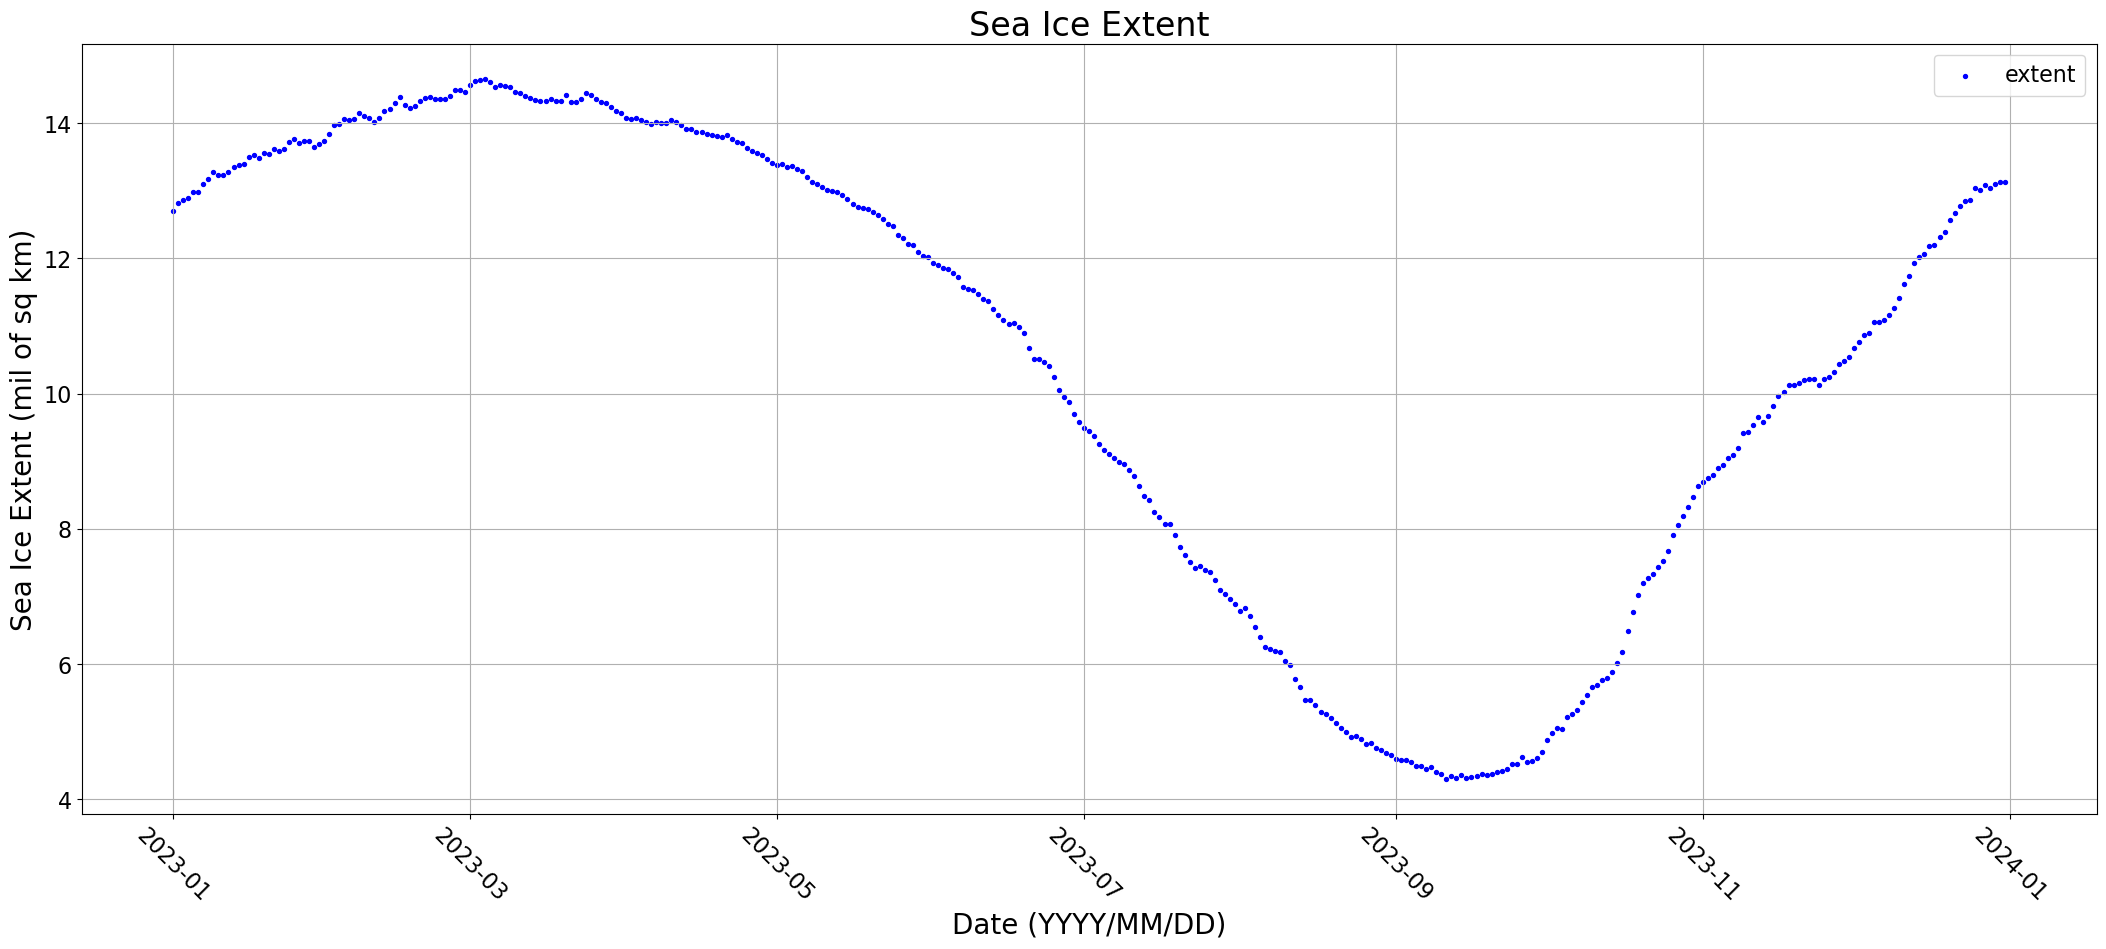

In [26]:
# Set up plot space
fig, ax1 = plt.subplots(figsize=(26, 10))

# Plot extent. Divide extent by 1 million to convert sq km to millions of sq km so that the y-axis values are easier to read
plt.scatter(extent_df['Date (yyyy/mm/dd)'], extent_df['Extent (km2)']/10e5, color='blue', 
            label='extent', s=8)
plt.title("Sea Ice Extent", fontsize=24)
# Set labels and ticks
plt.xlabel("Date (YYYY/MM/DD)", fontsize=20)
plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20)
plt.xticks(rotation=-45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

## Save the dataframe to a CSV file
Note: The code in the cell below is commented out so that a file won't be saved because a copy already exists in the GitHub repo. However, if you would like to save the file as part of your work with these notebooks, then uncomment out lines 2 and 4 below.

In [21]:
# CSV filename
#cdr_fn = 'data_files/cdr_sie_2023.csv'
# Save the dataframe to the CSV file
#extent_df.to_csv(cdr_fn, sep=',', index=False)